In [14]:
%matplotlib inline
import pywt                     # sudo pip3 install pywavelets
import matplotlib.pyplot as plt # sudo apt-get install python3-matplotlib
import numpy as np              # sudo apt-get install python3-numpy
import math

In [15]:
lenna = plt.imread("images/lenna.png")

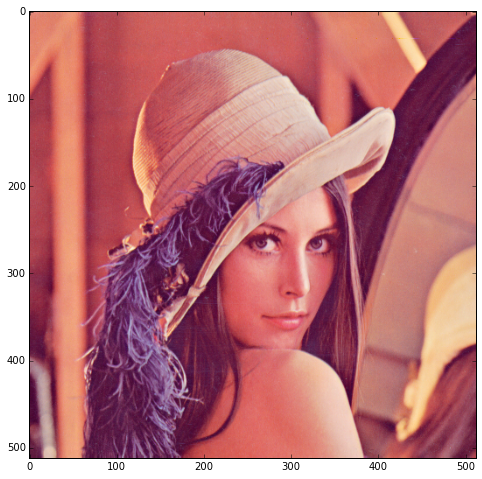

In [52]:
plt.figure(figsize=(8,8))
plt.imshow(lenna)

In [17]:
lenna.shape

(512, 512, 3)

In [18]:
lennaGray = (lenna[:,:,0]  + lenna[:,:,1] + lenna[:,:,2]) / 3

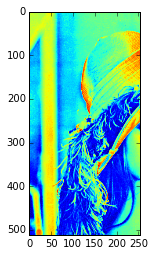

In [19]:
plt.imshow(lennaGray[:,0:255])

In [12]:
coeffs = pywt.dwt2(lennaGray,'haar')

In [13]:
cA, (cH, cV, cD) = coeffs

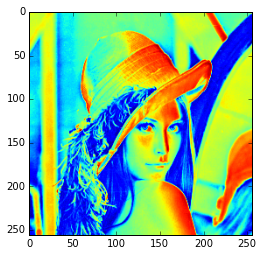

In [14]:
plt.imshow(cA)

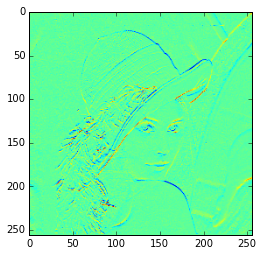

In [15]:
plt.imshow(cH)

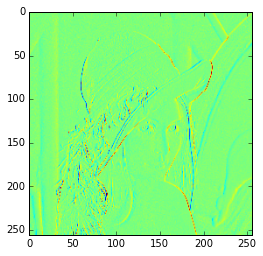

In [16]:
plt.imshow(cV)

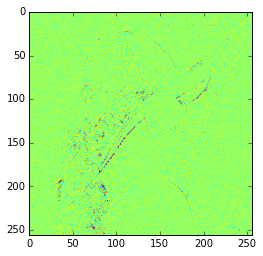

In [17]:
plt.imshow(cD)

In [14]:
def pixelDiff(image, ay, ax, by, bx, threshold):
    (height, width) = image.shape
    
    a = image[ay, ax]
    b = image[by, bx]
    return np.sum((a-b)**2) <= threshold**2

In [21]:
def discoverRegion(image, raster, yseed, xseed, threshold):
    assert(raster[yseed, xseed] == -1)
    region = np.max(raster) + 1
    queue = [(yseed, xseed)]
    raster[yseed,xseed] = region

    while len(queue) > 0:
        (y,x) = queue.pop(0)
        
        for (p,q) in [(y-1,x),(y+1,x),(y,x-1),(y,x+1)]:
            if raster[p,q] == -1 and pixelDiff(image, y, x, p, q, threshold):
                raster[p,q] = region
                queue.append((p,q))        

In [22]:
def fullRegionGrow(image, threshold):
    (height, width) = image.shape
    raster = np.zeros((height, width))-1
    
    # Write a board of -2 around the image.
    for y in range(height):
        raster[y,width-1] = -2
        raster[y,0] = -2
    for x in range(width):
        raster[height-1,x] = -2
        raster[0,x] = -2

    # Begin 
    for y in range(height):
        for x in range(width):
            if raster[y,x] == -1:
                discoverRegion(image, raster, y, x, threshold)
    return raster

In [23]:
raster = fullRegionGrow(lennaGray, 4/256)

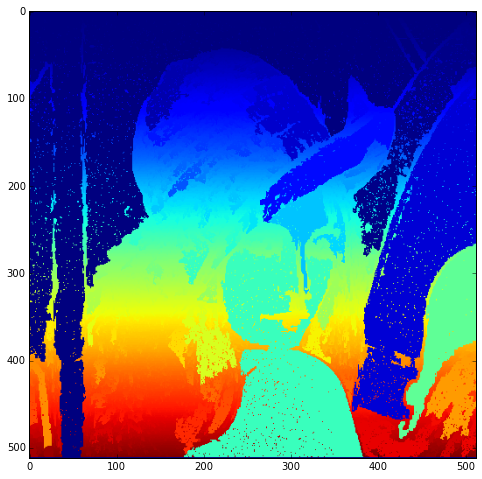

In [20]:
plt.figure(figsize=(8,8))
plt.imshow(raster)

In [24]:
def isSkinTone(pixel, redblue, greenblue, threshold=0.05):
    redEstimate = pixel[2] * redblue
    greenEstimate = pixel[2] * greenblue
    redError = math.fabs(pixel[0] - redEstimate)/redEstimate
    greenError = math.fabs(pixel[1] - greenEstimate)/greenEstimate

    return redError <= threshold and greenError <= threshold

In [44]:
def isSkinToneWhite(pixel, threshold=0.05):
    return isSkinTone(pixel, 1.5, 1.15, threshold)

def isSkinToneBlack(pixel, threshold=0.05):
    return isSkinTone(pixel, 2.84, 1.29, threshold)

def isSkinToneAsian(pixel, threshold=0.05):
    return isSkinTone(pixel, 1.65, 1.25, threshold)

def isSkinToneAllRaces(pixel, threshold=0.05):
    return isSkinToneWhite(pixel, threshold) or \
           isSkinToneBlack(pixel, threshold) or \
           isSkinToneAsian(pixel, threshold)

In [45]:
def getSkinRaster(image, threshold=0.05):
    (height, width, numslots) = image.shape
    raster = np.zeros((height, width))

    # Begin 
    for y in range(height):
        for x in range(width):
            if isSkinToneAllRaces(image[y,x], threshold):
                raster[y,x] = 1
    return raster

In [56]:
skinraster = getSkinRaster(lenna, 0.1)

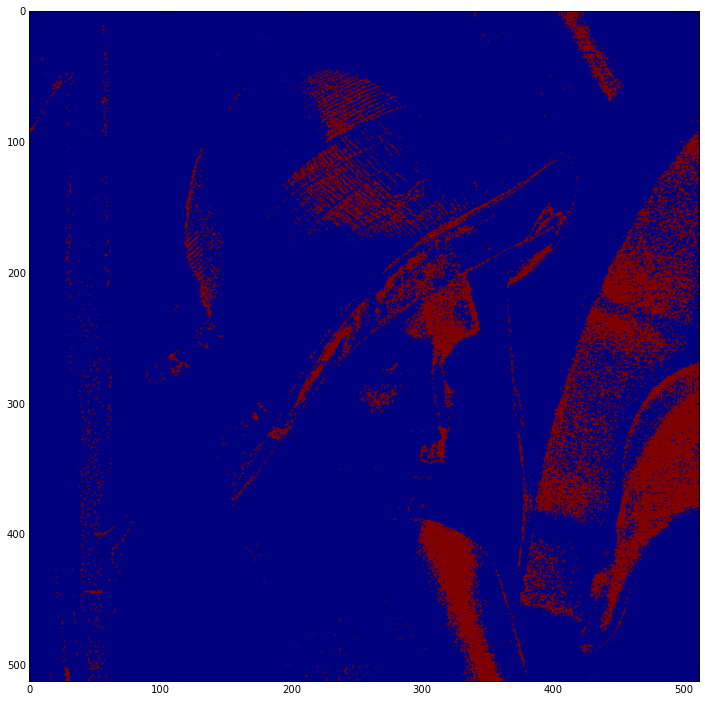

In [57]:
plt.figure(figsize=(12,12))
plt.imshow(skinraster)